# 4.2. Linear regression + features engineering

## Environment setup

### Install TGL package

In [452]:
import os

In [453]:
os.environ['PATH'] = "/Users/ivandonofrio/Workplace/Notebooks/venv/bin:" + os.environ['PATH']

In [454]:
%%sh
git clone git@github.com:donofiva/TemporalGraphLearning.git
cd TemporalGraphLearning
pip install .
cd ..
rm -r TemporalGraphLearning

Cloning into 'TemporalGraphLearning'...


Processing /Users/ivandonofrio/Workplace/Notebooks/TemporalGraphLearning
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for temporal_graph_learning: filename=temporal_graph_learning-0.0.1-py3-none-any.whl size=13162 sha256=aad5231ef44e292b05d168e7bf11959daf699a7c5b29ae29b0e459c086b5a5da
  Stored in directory: /private/var/folders/qv/mvb8szpn0zgfn8vn02k7c24m0000gn/T/pip-ephem-wheel-cache-drog595g/wheels/39/db/05/f395aacb8d67d0f880772d6a24131398880b7ba726b6f1820e
Successfully built temporal_graph_learning
  Attempting uninstall: temporal_graph_learning
    Found existing installation: tempo

### Install dependencies

In [455]:
!pip install numpy

In [456]:
!pip install scipy

In [457]:
!pip install pandas

In [458]:
!pip install matplotlib

In [459]:
!pip install seaborn

In [460]:
!pip install scikit-learn

### Define constants and configurations

In [461]:
INPUT_PATH = 'inputs'

## Dependencies

In [462]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [463]:
from temporal_graph_learning.abstraction.Dataset import Dataset
from temporal_graph_learning.abstraction.Timeseries import Timeseries
from temporal_graph_learning.charts.Plots import Plots
from temporal_graph_learning.charts.Plot import Plot
from temporal_graph_learning.charts.Histogram import Histogram
from temporal_graph_learning.charts.Lineplot import Lineplot
from temporal_graph_learning.charts.IdentityLine import IdentityLine
from temporal_graph_learning.charts.Heatmap import Heatmap
from temporal_graph_learning.charts.Scatterplot import Scatterplot
from temporal_graph_learning.charts.Text import Text
from temporal_graph_learning.charts.AutoCorrelation import AutoCorrelation
from temporal_graph_learning.io.FileManager import FileManager
from temporal_graph_learning.data.impute.LinearInterpolationImputer import LinearInterpolationImputer
from temporal_graph_learning.models.MultiTargetLinearRegression import MultiTargetLinearRegression

In [464]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [465]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

## Read data

In [466]:
timeseries = pd.read_csv('inputs/timeseries_outliers.csv')

In [467]:
timeseries = timeseries[timeseries.TURBINE == 1].reset_index(drop=True)

## Processing

In [468]:
timeseries = timeseries.dropna(ignore_index=True)

In [469]:
timeseries['PITCH_ANGLE_BLADES'] = timeseries[[
    'PITCH_ANGLE_FIRST_BLADE',
    'PITCH_ANGLE_SECOND_BLADE',
    'PITCH_ANGLE_THIRD_BLADE'
]].mean(axis=1)

In [470]:
timeseries['WIND_DIRECTION'] = np.cos(np.radians(timeseries['WIND_DIRECTION']))

In [471]:
timeseries = timeseries.drop(
    columns=[
        'TURBINE', 
        'DAY', 
        'TIMESLOT',
        'PITCH_ANGLE_FIRST_BLADE',
        'PITCH_ANGLE_SECOND_BLADE',
        'PITCH_ANGLE_THIRD_BLADE'
    ]
)

## Training

In [472]:
X = timeseries.drop(columns=['ACTIVE_POWER'])

In [473]:
y = timeseries['ACTIVE_POWER']

In [474]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, shuffle=True)

In [475]:
pipeline = Pipeline([
    ('polynomial_features', PolynomialFeatures(2, interaction_only=True)),
    ('regressor', LinearRegression())
])

In [476]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomial_features',
                 PolynomialFeatures(interaction_only=True)),
                ('regressor', LinearRegression())])

In [477]:
y_hat = pipeline.predict(X_test)

## Residuals plot

In [478]:
residual_scatterplot = Scatterplot(opacity=0.05)
identity_line = IdentityLine()

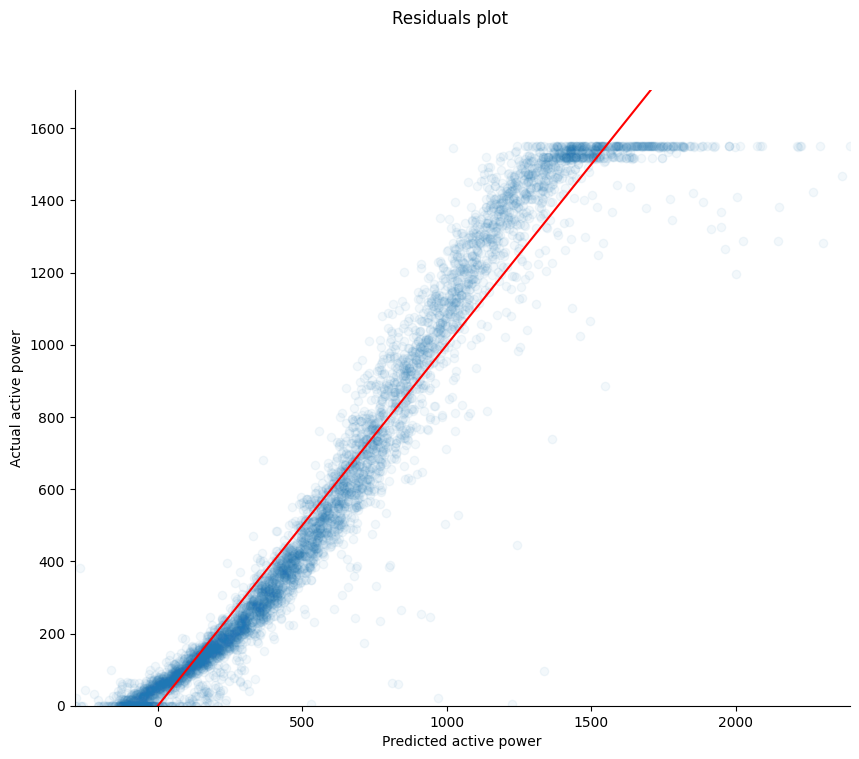

In [479]:
# Initialize plots
plots = Plots(1, 1, 10, 8)
plot = plots.get_plot_from_list_by_index(0)

# Draw scatterplot
identity_line.draw_on_plot(plot)
residual_scatterplot.draw_on_plot(
    y_hat,
    y_test.values,
    plot
)

# Configure plot
plot.toggle_top_and_right_border(False)
plot.set_x_axis_boundaries(y_hat.min(), y_hat.max())
plot.set_y_axis_boundaries(y_test.values.min(), y_test.values.max() * 1.1)
plot.set_axis_labels('Predicted active power', 'Actual active power')
plots.set_title('Residuals plot')

## Feature importance

In [480]:
feature_to_feature_importance = dict(
    zip(
        pipeline.named_steps['polynomial_features'].get_feature_names_out(X_train.columns),
        pipeline.named_steps['regressor'].coef_
    )
)

In [481]:
feature_to_feature_importance = pd.DataFrame(
    feature_to_feature_importance.items(), 
    columns=['DIMENSION', 'WEIGHT']
)

feature_to_feature_importance.sort_values('WEIGHT', ignore_index=True)

,DIMENSION,WEIGHT
0,WIND_DIRECTION,-4.907660e+02
1,WIND_SPEED,-1.452397e+02
2,WIND_DIRECTION EXTERNAL_TEMPERATURE,-1.514204e+01
3,INTERNAL_TEMPERATURE,-8.589375e+00
4,REACTIVE_POWER,-7.388296e+00
5,WIND_SPEED PITCH_ANGLE_BLADES,-4.120630e+00
6,WIND_SPEED EXTERNAL_TEMPERATURE,-3.289625e+00
7,INTERNAL_TEMPERATURE PITCH_ANGLE_BLADES,-9.110084e-01
8,EXTERNAL_TEMPERATURE INTERNAL_TEMPERATURE,-2.250666e-01
9,WIND_DIRECTION NACELLE_DIRECTION,-2.189673e-01


## Validation

In [482]:
cross_validation = cross_validate(
    pipeline,
    X,
    y,
    cv=KFold(shuffle=True),
    scoring=[
        'neg_mean_absolute_error',
        'neg_root_mean_squared_error',
        'r2'
    ]
)

In [483]:
pd.DataFrame(cross_validation)

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2
0,0.095175,0.036419,-88.623389,-127.090120,0.939239
1,0.265122,0.053099,-89.183718,-131.168690,0.936687
2,0.236075,0.047200,-90.815178,-132.148283,0.935927
3,0.237539,0.028250,-91.119023,-130.650084,0.938288
4,0.261423,0.042467,-89.779042,-126.522849,0.941246
